This is the notebook of kaggle competition "House Prices - Advanced Regression Techniques"

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.7.0
2.7.0


In [2]:
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import pandas as pd

def load_digits_data(digits_path='data'):
    train_csv_path = os.path.join(digits_path, "train.csv")
    test_csv_path = os.path.join(digits_path, "test.csv")
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train, test = load_digits_data()

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

In [5]:
y_train = train['label']

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = train.iloc[:, 1:]
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
train = X_train_scaled.reshape(X_train_scaled.shape[0],28,28,1)
test_scaled = scaler.transform(test.astype(np.float64))
test = test_scaled.reshape(test_scaled.shape[0],28,28,1)

In [9]:
train_aug = np.zeros((train.shape[0]*3, train.shape[1], train.shape[2], train.shape[3]))

In [10]:
train_aug[:train.shape[0],:,:,:] = train.copy()

In [11]:
data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    preprocessing.RandomContrast(factor=0.10),
])

In [12]:
# plt.figure(figsize=(10, 10))
for i in range(train.shape[0]):
    augmented_image = data_augmentation(train[i])
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_image[0])
#     plt.imshow(augmented_image[:,:,0], cmap=mpl.cm.binary)
#     plt.imshow(train[0, :, :, 0], cmap=mpl.cm.binary)
#     plt.axis("off")
#     print(augmented_image.shape)
#     print(type(augmented_image))
#     print(type(train))
#     print(i)
    train_aug[train.shape[0]+i,:,:,:] = augmented_image.numpy().reshape((1,28,28,1)).copy()
#     train_aug = np.concatenate((train_aug, augmented_image.numpy().reshape((1,28,28,1))), axis=0)

for i in range(train.shape[0]):
    augmented_image = data_augmentation(train[i])
    train_aug[2*train.shape[0]+i,:,:,:] = augmented_image.numpy().reshape((1,28,28,1)).copy()
    


In [13]:
train_aug.shape

(126000, 28, 28, 1)

In [20]:
# plt.imshow(train_aug[125999, :, :, 0], cmap=mpl.cm.binary)
# plt.imshow(train_aug[83999, :, :, 0], cmap=mpl.cm.binary)
# plt.imshow(train_aug[41999, :, :, 0], cmap=mpl.cm.binary)

In [21]:
y_train = pd.concat([y_train, y_train, y_train], axis=0, ignore_index=True)

In [22]:
y_train.tail()

125995    0
125996    1
125997    7
125998    6
125999    9
Name: label, dtype: int64

In [23]:
y_binary = to_categorical(y_train.values)

In [24]:
train_aug.shape

(126000, 28, 28, 1)

In [25]:
y_binary.shape

(126000, 10)

In [26]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[28, 28, 1]),
    
#     preprocessing.RandomContrast(factor=0.10),
#     preprocessing.RandomFlip(mode='horizontal'),
#     preprocessing.RandomRotation(factor=0.10),
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[28, 28, 1]),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    
        # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax'),
])


In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [29]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

In [33]:
batch_size = 100
epochs = 50

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_aug, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2)


Epoch 1/50
1008/1008 [==============================] - 115s 114ms/step - loss: 0.0449 - categorical_accuracy: 0.9863 - val_loss: 0.0367 - val_categorical_accuracy: 0.9894
Epoch 2/50
1008/1008 [==============================] - 111s 110ms/step - loss: 0.0351 - categorical_accuracy: 0.9892 - val_loss: 0.0351 - val_categorical_accuracy: 0.9896
Epoch 3/50
1008/1008 [==============================] - 115s 114ms/step - loss: 0.0302 - categorical_accuracy: 0.9903 - val_loss: 0.0335 - val_categorical_accuracy: 0.9908
Epoch 4/50
1008/1008 [==============================] - 139s 138ms/step - loss: 0.0245 - categorical_accuracy: 0.9923 - val_loss: 0.0247 - val_categorical_accuracy: 0.9933
Epoch 5/50
1008/1008 [==============================] - 108s 107ms/step - loss: 0.0213 - categorical_accuracy: 0.9934 - val_loss: 0.0290 - val_categorical_accuracy: 0.9926
Epoch 6/50
1008/1008 [==============================] - 108s 107ms/step - loss: 0.0185 - categorical_accuracy: 0.9941 - val_loss: 0.0269 - v

(0.985, 1.0)

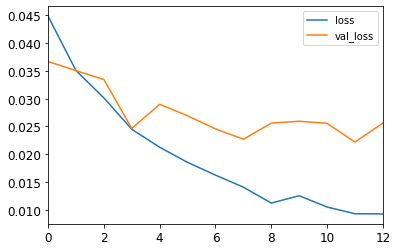

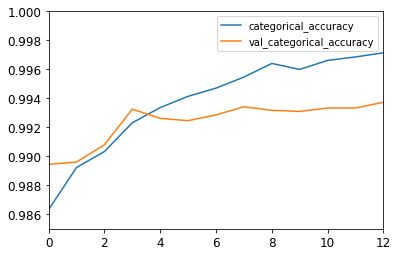

In [38]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.ylim([0.985, 1.0])

In [39]:
predictions = model.predict(test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [40]:
predictions_cat = predictions.argmax(axis=1)

In [41]:
predictions_cat.shape

(28000,)

In [42]:
sub = pd.DataFrame({'ImageId': list(range(1, len(predictions_cat)+1)), 'Label': predictions_cat})
sub.shape

(28000, 2)

In [43]:
sub.to_csv("data/submission_script15.csv", index=False)

In [47]:
train_aug.tofile('data/input_data_augmented.csv', sep=",")